In [1]:
### Created by Ian Nesbitt, University of Maine, using RaspberryShake UDP documentation:
### https://manual.raspberryshake.org/udp.html

### Live updating plot created using the following as a template:
### https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# NOTE: I don't know why, but you have to run the import cells twice in order for this to work.
# If someone can figure out why, or find a less dirty workaround, please let me know.
# ian dot nesbitt at gmail dot com

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Waiting for data on Port: 18002


<IPython.core.display.Javascript object>


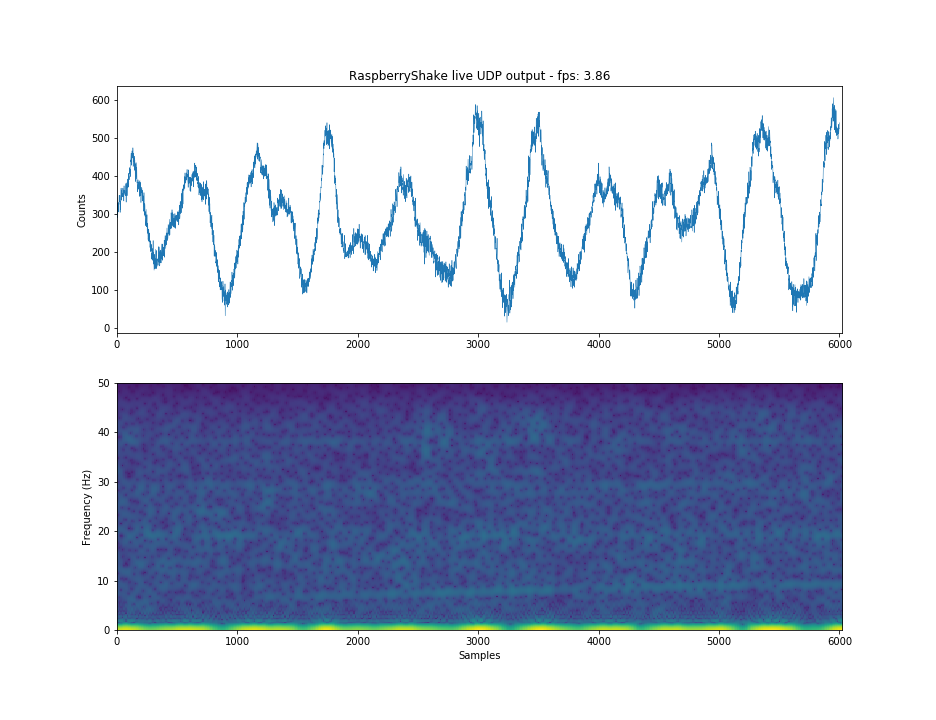

/home/iannesbitt/anaconda3/lib/python3.6/site-packages/matplotlib/mlab.py:1274: UserWarning: Only one segment is calculated since parameter NFFT (=128) >= signal length (=50).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))
/home/iannesbitt/anaconda3/lib/python3.6/site-packages/matplotlib/mlab.py:1274: UserWarning: Only one segment is calculated since parameter NFFT (=128) >= signal length (=100).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


In [ ]:
import socket as s
import math as M
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

ch = 'EHZ'                               # pick your favorite channel
freq = 100                               # sampling frequency in Hz of rshake (1D = 50; 3D & 4D = 100)
seconds = 60                             # number of seconds of data to display
host = ''                                # blank for localhost (data is being sent here by remote Shake!)
port = 18002                             # Port to bind to

displ_samps = seconds * freq
wlen = freq / 100
per_lap = 0.9
mult = 8.0
sock = s.socket(s.AF_INET, s.SOCK_DGRAM | s.SO_REUSEADDR)
sock.bind((host, port))

print('Waiting for data on Port:', port)

# from https://docs.obspy.org/_modules/obspy/imaging/spectrogram.html#_nearest_pow_2:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

nfft = int(_nearest_pow_2(wlen * freq))
if mult is not None:
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft

#initialize the graph and settings
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13,10))
plt.ion()

fig.show()
fig.canvas.draw()

stream = []                             # our stream (simple list object)
curr = datetime.now()

while 1:                                # loop forever
    data, addr = sock.recvfrom(1024)    # wait to receive data
    s = data.decode('UTF-8').strip("'{} ").split(', ') # clean and listify the data
    if ch in s[0]:                      # only listen to the specific channel
        prev = curr                     # timing
        curr = datetime.now()           # timing
        td = curr - prev                # timing
        fps = 1/td.total_seconds()      # timing
        ax1.clear()                     # ready the plot axis for a new draw
        for smp in s[2:]:               # convert strings
            stream.append(int(smp))
        npts = len(stream)
        if npts > displ_samps:          # 6000 samples per minute
            stream = stream[-displ_samps:]     # move the array to the right, get rid of old samples
        ax1.plot(stream, linewidth=0.5)
        ax1.set_xlim(0, npts)
        if nfft > npts:
            nfft = int(_nearest_pow_2(npts / 8.0))
        else:
            nfft = int(_nearest_pow_2(wlen * freq))
        nlap = int(nfft * float(per_lap))
        specgram, frq, time, im = ax2.specgram(stream, NFFT=nfft, pad_to=mult, Fs=freq, noverlap=nlap)
        ax2.clear()                     # ditch default spectrogram display, ready axis for new image
        specgram = np.cbrt(np.cbrt(specgram[1:, :]))  # cubed root of cubed root (=9th root) to increase gain
        specgram = np.flipud(specgram)
        extent = (0, npts,
                  0, freq/2)
        ax2.imshow(specgram, interpolation="nearest", extent=extent, aspect='auto')
        ax2.set(xlabel='Samples', ylabel='Frequency (Hz)')
        ax1.set(title='RaspberryShake live UDP output - fps: %.2f' % (fps), ylabel='Counts')
        fig.canvas.draw()